In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units as u
from astropy import constants as c

In [2]:
import sys
from spin_class import * 

In [3]:
path = '/Users/veomekapil/Library/CloudStorage/OneDrive-JohnsHopkins/Research/spins_in_field/Z_0.001/COMPAS_Output.h5' # change this line! 


In [4]:
# some plotting code, it should be fairly straightforward what the code does


def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 25, second=False, labelpad=None, setMinor=True, ):
    """
    Some code to do the layout for axes in matplotlib in a nice way 
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')


    if labelSizeMajor==10:
        ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    else:
        ax.set_xlabel(nameX, fontsize=labelSizeMajor,labelpad=labelpad)#,fontweight='bold')
        ax.set_ylabel(nameY, fontsize=labelSizeMajor,labelpad=labelpad)#, fontweight='bold')  

    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax

    


def plot_histogram_spin(spin_values, spin_model_name, weights=None, yscaleLOG=False):
    """
    Creates weighted histogram of black hole spins (spin_values)
    """

    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.hist(spin_values, density=True, bins=20)

    ylabel=r'PDF (rate) ' 
    xlabel=r'spin orientation'

    plt.xlim(0, np.pi)
    
    if yscaleLOG==True:
        ax.set_yscale('log')

    plt.title('spin orientation: ' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    plt.show()



    
    
    
def plot_scatter_general(xx, yy, cc, spin_model_name, ylabel=r'Period [day]', xlabel=r'$m_{\rm{WR}} \, [M_{\odot}]$ '):




    f, ax= plt.subplots(ncols=1,nrows=1, figsize=(8,5))

    plt.scatter(xx[0:100000], yy[0:100000],  c=cc[0:100000])




#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(1, 70)
#     plt.ylim(0.05, 10)

    cbar = plt.colorbar()
    cbar.set_label('spin', fontsize=20)
    cbar.ax.tick_params(labelsize='large')

    plt.title('spin' + spin_model_name)
    layoutAxes(ax=ax, nameX=xlabel, nameY=ylabel,setMinor=False, fontsize=16)
    f.tight_layout() 
    # plt.savefig('./BBH_COMPAS_model_A.png', dpi=600)#,\
    plt.show()
    
    
    

In [5]:
class calculate_spin_orientation(object):
    """
    This class calculates the Black Hole (BH) or Neutron Star (NS) spin based on a given spin prescription
    It returns the spin of the compact object M1, and compact object M2    
    """

    
    def __init__(self, data_path=None, spin_model_name='uniform'):
    
        self.path                = data_path
        
        if (self.path is None):
            print("Warning: your hdf5 path is set to 'None'")
        elif not  os.path.isfile(data_path):
            raise ValueError("h5 file not found. Wrong path given?", "path given = %s"%data_path)
        elif os.path.isfile(data_path):
            self.h5file           = h5.File(data_path)
            
            
        self.spin_model_name = spin_model_name
        
    

    def fixed_value_spin_orientation(self, spin_theta):   
        """
        returns black hole spins with a fixed spin orientation 'spin_theta'
        """
        M1samples = self.h5file['BSE_Double_Compact_Objects']['Mass(1)'][...].squeeze()
        
        self.theta1 = np.ones_like(a=M1samples) * spin_theta
        self.theta2 = np.ones_like(a=M1samples) * spin_theta
        
        return self.theta1, self.theta2


    def natal_kick_misalignment(self):
        """
        Returns spinTheta1 and spinTheta2, the spin orientations of the compact objects formed from
        the initial most massive star (M1) and initial least massive star (M2), respectively. 
        
        In this model only the natal kicks contribute to a spin misalignment. 

        Based on Eq 20 from https://arxiv.org/abs/2010.00078
    
        """
        
        # the following function reads in the COMPAS DCO parameters such as natal kick velocity and sets self.spinTheta1, self.spinTheta2 
        # to arrays of zeros
        self.setCOMPASData() 
        
        ## Calculate spin for the ones that tidally spin up ##
                
        # define mask of BHs that went SN first
        # if BH (self.st==14) & formed first (self.M1formedSecond==0), use Eq. (20) to compute the spin orientation angle Theta.
        maskM1_is_SN1 = (self.M1formedSecond==0)
        maskM2_is_SN1 = (self.M1formedSecond==1)

        maskM1_is_SN2 = (self.M1formedSecond==1)
        maskM2_is_SN2 = (self.M1formedSecond==0)

        u_k = self.SN_v_kick / self.SN_v_orb

        # Eq. 20 (First SN): 
        first_term = ( 1+ (u_k * np.cos(self.SN_kick_theta)) )
        second_term =  ( u_k * np.sin(self.SN_kick_theta) * np.cos(self.SN_kick_phi))  
        cos_Theta = first_term / np.sqrt((first_term**2) + (second_term)**2)

        # Calculate the spin thetas for when the tilt is caused by SN1
        self.theta1[maskM1_is_SN1]  =  np.arccos(cos_Theta)[self.mask_SN_is_M1][maskM1_is_SN1]
        self.theta2[maskM2_is_SN1]  =  np.arccos(cos_Theta)[self.mask_SN_is_M2][maskM2_is_SN1]

        # Calculate the second spin theta simply based on the kick (This is simplistic)
        self.theta1[maskM1_is_SN2]  =  np.arccos(cos_Theta)[self.mask_SN_is_M1][maskM1_is_SN2]
        self.theta2[maskM2_is_SN2]  =  np.arccos(cos_Theta)[self.mask_SN_is_M2][maskM2_is_SN2]


        # # any BHs that experienced SN will have tilted spins, all others will have gamma = 0 after tidal alignment
        # gamma1 = self.theta1 
        # gamma2 = self.theta2

        # # Eq. 21 (Second SN):
        # # S1
        # first_term = ( 1+ (u_k * np.cos(self.SN_kick_theta)) ) * np.cos(gamma1)
        # second_term =  ( u_k * np.sin(self.SN_kick_theta) * np.cos(self.SN_kick_phi))  
        # cos_Theta = first_term / np.sqrt((first_term**2) + (second_term)**2)

        # # Calculate the spin thetas for when the tilt is caused by SN2, with the initial spin being aligned with L
        # self.theta1[maskM1_is_SN2]  =  np.arccos(cos_Theta)[self.mask_SN_is_M1][maskM1_is_SN2]
        # self.theta2[maskM2_is_SN2]  =  np.arccos(cos_Theta)[self.mask_SN_is_M2][maskM2_is_SN2]
        
        
        return self.theta1, self.theta2


    def convert_a_to_P_circular(self, separation, M1, M2):
        """calculate Period from separation
        separation is separation (needs to be given in astropy units)
        M1 and M2 are masses of the binary

        """
        G = c.G # [gr cm s^2]


        mu = G*(M1+M2)
        self.PeriodPreSN2 = 2*np.pi * np.sqrt(separation**3/mu)
        
    def setCOMPASData(self):
        """ reads in some of the COMPAS parameters needed from hdf5 file """
        

        # """ reads in some of the COMPAS parameters needed from hdf5 file """

        fDCO      = self.h5file['BSE_Double_Compact_Objects'] # hdf5 file with the DCO information
        fSN       = self.h5file['BSE_Supernovae']  # hdf5 file with the SN information
        fini      = self.h5file['BSE_System_Parameters']  # hdf5 file with initial parameters
        # #
        self.SEED_dco = fDCO['SEED'][...].squeeze()


        
        mask_dco_SN  = np.in1d(fSN['SEED'][...].squeeze(), self.SEED_dco) # mask in the SNe files the SNe that correspond to our DCO               
        # first, remove simulteneous_SN
        whichSN = fSN['Supernova_State'][...].squeeze()[mask_dco_SN] 
        mask_no_simulteneous_SN = (whichSN[0::2]!=3) & (whichSN[1::2]!=3)
        
        # remove BNS
        self.st1 = fDCO['Stellar_Type(1)'][...].squeeze()
        self.st2 = fDCO['Stellar_Type(2)'][...].squeeze()
        
        mask_contains_BH = ((self.st1==14) | (self.st2==14)) & (mask_no_simulteneous_SN==1)
        
        
        mask_dco_ini  = np.in1d(fini['SEED'][...].squeeze(), self.SEED_dco[mask_contains_BH]) #  update mask removing simulteneous SNe
        mask_dco_SN   = np.in1d(fSN['SEED'][...].squeeze() , self.SEED_dco[mask_contains_BH]) #  update mask removing simulteneous SNe      

        self.st1 =  self.st1[mask_contains_BH]
        self.st2 =  self.st2[mask_contains_BH]
        self.M1 = fDCO['Mass(1)'][...].squeeze()[mask_contains_BH]   # Compact object mass [Msun] of the initially more massive star
        self.M2 = fDCO['Mass(2)'][...].squeeze()[mask_contains_BH]  # Compact object mass [Msun] of the initially less massive star

        
        
        mask_dco_ini  = np.in1d(fini['SEED'][...].squeeze(), self.SEED_dco[mask_contains_BH]) # mask in the initial parameter files the SNe that correspond to our DCO that are BHs
        mask_dco_SN  = np.in1d(fSN['SEED'][...].squeeze(), self.SEED_dco[mask_contains_BH]) # mask in the SNe files the SNe that correspond to our DCO that are BHs        
        
        
        self.metallicitySystems  = fini['Metallicity@ZAMS(1)'][...].squeeze()[mask_dco_ini] 

        whichSN = fSN['Supernova_State'][...].squeeze()[mask_dco_SN]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
        whichSN2 = whichSN[1::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       
        self.mask_SN_is_M1 = (whichSN==1)
        self.mask_SN_is_M2 = (whichSN==2) 
        
        self.separationPreSN2= fSN['SemiMajorAxis<SN'][...].squeeze()[mask_dco_SN][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  

        self.convert_a_to_P_circular(separation=self.separationPreSN2*u.Rsun, M1=self.M1*u.Msun, M2=self.M2*u.Msun)  # obtain the Period before the SNe
        self.PeriodPreSN2 = self.PeriodPreSN2.to(u.d).value
        self.MassCOM1CoreSN = fSN['Mass_CO_Core@CO(SN)'][...].squeeze()[mask_dco_SN][self.mask_SN_is_M1]   # obtain the CO core mass before the SNe when M1 goes SN
        self.MassCOM2CoreSN = fSN['Mass_CO_Core@CO(SN)'][...].squeeze()[mask_dco_SN][self.mask_SN_is_M2]   # obtain the CO core mass before the SNe when M2 goes SN

        # self.SN_v_kick = fSN['ComponentSpeed(SN)'][...].squeeze()[mask_dco_SN]   # obtain the SN kick velocity
        self.SN_v_kick = fSN['Drawn_Kick_Magnitude(SN)'][...].squeeze()[mask_dco_SN]   # obtain the SN kick velocity

        self.SN_v_orb = fSN['Orb_Velocity<SN'][...].squeeze()[mask_dco_SN]   # obtain the orbital velocity before SN
        self.SN_kick_theta = fSN['SN_Kick_Theta(SN)'][...].squeeze()[mask_dco_SN]   # obtain the SN kick theta 
        self.SN_kick_phi = fSN['SN_Kick_Phi(SN)'][...].squeeze()[mask_dco_SN]  # obtain the SN kick phi

        self.theta1, self.theta2 = np.zeros_like(self.M1), np.zeros_like(self.M2)  # start by giving all primaries zero spin and all secondaries zero spin 
        # # did M1 form in the first SN?
        self.M1formedSecond =  (whichSN2==1) # mask that is 1 if the  compact object M1 formed first in the DCO
        # # did M2 form in the first SN?
        self.M2formedSecond =  (whichSN2==2)  # mask that is 1 if the compact object M2 formed first in the DCO
        # Wolf-Rayet mass 
        self.mWR =  fSN['Mass_Total@CO(SN)'][...].squeeze()[mask_dco_SN][1::2]   # obtain the WR mass before the SNe

# Model 0: Spins are aligned

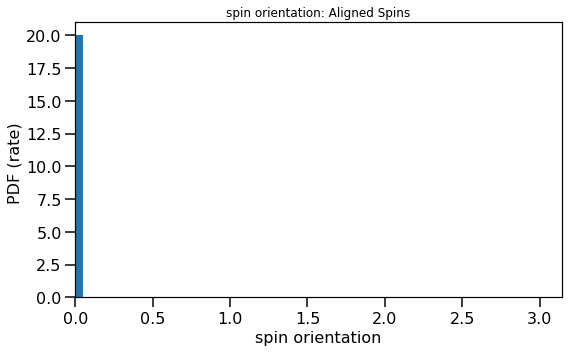

In [6]:
spin_orientation = calculate_spin_orientation(data_path=path)
spinTheta1, spinTheta2  = spin_orientation.fixed_value_spin_orientation(spin_theta=0)

plot_histogram_spin(spin_values=(spinTheta1), spin_model_name='Aligned Spins')

# Model 1: Spins-orbit misalignment from natal kicks 

Following Steinle & Kesden 2021 (https://arxiv.org/abs/2010.00078), Section C.4, we calculate the spin misalignent from the action of a natal kick that tilts the orbital plane. For initially alligned spins, the angle $\Theta$ between the spins $\vec{S_i}$ and the orbital angular momentum $\vec{L}$ following the natal kick is given by Eq. (20):

$$ \cos \Theta = \frac{1+ u_k \cos \theta_k}{[ (1+ u_k \cos \theta_k)^2 + (u_k \sin \theta_k \cos \phi_k)^2]^{1/2}} $$

where $u_k \equiv v_k / v_{orb}$, $\phi_k$ is the azimuthal angle of the kick in the plane perpendicular to the orbit. $\phi_k = 0$ means that the kick is aligned with $\vec{L}$.

For simplicity, we assume no spin precession between SN1 and SN2, such that the only dominant change in spin orientation is due to *tidal realignment*. 

Thus, the angle $\gamma$ between $\vec{S_2}$ and $\vec{L}$ is 0 before SN2. After SN2, the angles $\theta_i$ between each spin $\vec{S_i}$ and $\vec{L}$ are given by Eq. (21):
$$ \cos \theta_i = \frac{(1+ u_k \cos \theta_k) \cos \gamma_i - u_k \sin \theta_k\cos \phi_k \sin \gamma_i \sin \omega_i}{ [(1+ u_k \cos \theta_k)^2 + (u_k \sin \theta_k \cos \phi_k)^2]^{1/2}} $$

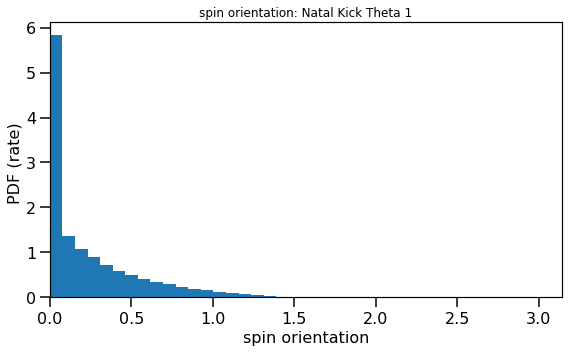

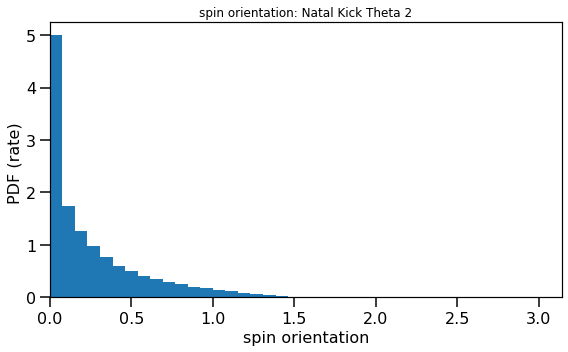

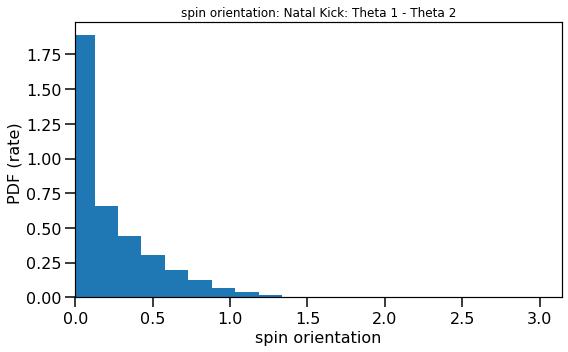

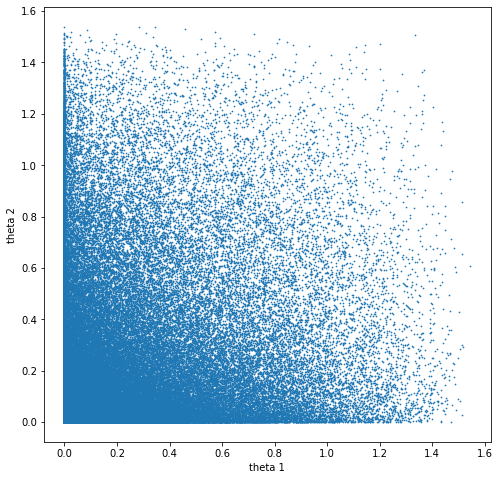

In [12]:
spin_orientation = calculate_spin_orientation(data_path=path)
spinTheta1, spinTheta2  = spin_orientation.natal_kick_misalignment()

plot_histogram_spin(spin_values=(spinTheta1), spin_model_name='Natal Kick Theta 1')
plot_histogram_spin(spin_values=(spinTheta2), spin_model_name='Natal Kick Theta 2')

plot_histogram_spin(spin_values=(spinTheta1-spinTheta2), spin_model_name='Natal Kick: Theta 1 - Theta 2')

plt.rcParams["figure.figsize"] = (8,8)
plt.scatter(spinTheta1, spinTheta2, s=0.5)
plt.xlabel('theta 1')
plt.ylabel('theta 2')
plt.show()

# Workspace

In [133]:
h5file           = h5.File(path)

fDCO      = h5file['BSE_Double_Compact_Objects'] # hdf5 file with the DCO information
fSN       = h5file['BSE_Supernovae']  # hdf5 file with the SN information
fini      = h5file['BSE_System_Parameters']  # hdf5 file with initial parameters
# #
SEED_dco = fDCO['SEED'][...].squeeze()



mask_dco_SN  = np.in1d(fSN['SEED'][...].squeeze(), SEED_dco) # mask in the SNe files the SNe that correspond to our DCO               
# first, remove simulteneous_SN
whichSN = fSN['Supernova_State'][...].squeeze()[mask_dco_SN] 
mask_no_simulteneous_SN = (whichSN[0::2]!=3) & (whichSN[1::2]!=3)

# remove BNS
st1 = fDCO['Stellar_Type(1)'][...].squeeze()
st2 = fDCO['Stellar_Type(2)'][...].squeeze()

mask_contains_BH = ((st1==14) | (st2==14)) & (mask_no_simulteneous_SN==1)


mask_dco_ini  = np.in1d(fini['SEED'][...].squeeze(), SEED_dco[mask_contains_BH]) #  update mask removing simulteneous SNe
mask_dco_SN   = np.in1d(fSN['SEED'][...].squeeze() , SEED_dco[mask_contains_BH]) #  update mask removing simulteneous SNe      

st1 =  st1[mask_contains_BH]
st2 =  st2[mask_contains_BH]
M1 = fDCO['Mass(1)'][...].squeeze()[mask_contains_BH]   # Compact object mass [Msun] of the initially more massive star
M2 = fDCO['Mass(2)'][...].squeeze()[mask_contains_BH]  # Compact object mass [Msun] of the initially less massive star



mask_dco_ini  = np.in1d(fini['SEED'][...].squeeze(), SEED_dco[mask_contains_BH]) # mask in the initial parameter files the SNe that correspond to our DCO that are BHs
mask_dco_SN  = np.in1d(fSN['SEED'][...].squeeze(), SEED_dco[mask_contains_BH]) # mask in the SNe files the SNe that correspond to our DCO that are BHs        


metallicitySystems  = fini['Metallicity@ZAMS(1)'][...].squeeze()[mask_dco_ini] 

whichSN = fSN['Supernova_State'][...].squeeze()[mask_dco_SN]   # this is 1 if the initially primary star goes SN and 2 if the secondary goes supernova
whichSN2 = whichSN[1::2] # get whichStar for the first SN   (there are 2 SNe for all DCOs)       
mask_SN_is_M1 = (whichSN==1)
mask_SN_is_M2 = (whichSN==2) 

separationPreSN2= fSN['SemiMajorAxis<SN'][...].squeeze()[mask_dco_SN][1::2] # the separation just before each SN  in [Rsun], we need only the separation for the second SN to occur, so the [1::2]  


MassCOM1CoreSN = fSN['Mass_CO_Core@CO(SN)'][...].squeeze()[mask_dco_SN][mask_SN_is_M1]   # obtain the CO core mass before the SNe when M1 goes SN
MassCOM2CoreSN = fSN['Mass_CO_Core@CO(SN)'][...].squeeze()[mask_dco_SN][mask_SN_is_M2]   # obtain the CO core mass before the SNe when M2 goes SN

SN_v_kick = fSN['Drawn_Kick_Magnitude(SN)'][...].squeeze()[mask_dco_SN]   # obtain the SN kick velocity
SN_v_orb = fSN['Orb_Velocity<SN'][...].squeeze()[mask_dco_SN]   # obtain the orbital velocity before SN
SN_kick_theta = fSN['SN_Kick_Theta(SN)'][...].squeeze()[mask_dco_SN]   # obtain the SN kick theta 
SN_kick_phi = fSN['SN_Kick_Phi(SN)'][...].squeeze()[mask_dco_SN]  # obtain the SN kick phi

theta1, theta2 = np.zeros_like(M1), np.zeros_like(M2)  # start by giving all primaries zero spin and all secondaries zero spin 
# # did M1 form in the first SN?
M1formedSecond =  (whichSN2==1) # mask that is 1 if the  compact object M1 formed first in the DCO
# # did M2 form in the first SN?
M2formedSecond =  (whichSN2==2)  # mask that is 1 if the compact object M2 formed first in the DCO
# Wolf-Rayet mass 
mWR =  fSN['Mass_Total@CO(SN)'][...].squeeze()[mask_dco_SN][1::2]   # obtain the WR mass before the SNe

(array([225.,  60.,   6.,   4.,   1.,   2.,   0.,   1.,   0.,   1.]),
 array([0.        , 0.13798838, 0.27597677, 0.41396515, 0.55195354,
        0.68994192, 0.82793031, 0.96591869, 1.10390708, 1.24189546,
        1.37988385]),
 <BarContainer object of 10 artists>)

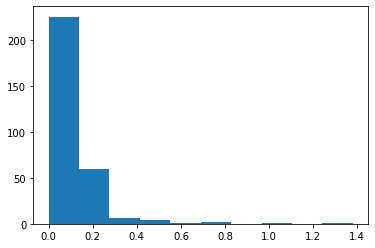

In [161]:
maskM1_is_SN1 = (M1formedSecond==0)
maskM2_is_SN1 = (M1formedSecond==1)

# u_k = SN_v_kick[mask_SN_is_M1][maskM1_is_SN1] / SN_v_orb[mask_SN_is_M1][maskM1_is_SN1]
# sn_theta = SN_kick_theta[mask_SN_is_M1][maskM1_is_SN1]
# sn_phi = SN_kick_phi[mask_SN_is_M1][maskM1_is_SN1]

u_k = SN_v_kick[mask_SN_is_M2][maskM2_is_SN1] / SN_v_orb[mask_SN_is_M2][maskM2_is_SN1]
sn_theta = SN_kick_theta[mask_SN_is_M2][maskM2_is_SN1]
sn_phi = SN_kick_phi[mask_SN_is_M2][maskM2_is_SN1]

# # Eq. 20: 
first_term = ( 1+ (u_k * np.cos(sn_theta)) )
second_term =  ( u_k * np.sin(sn_theta) * np.cos(sn_phi))  
cos_Theta = first_term / np.sqrt((first_term**2) + (second_term)**2)

plt.hist(np.arccos(cos_Theta))